In [125]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz
from utils import sample_PLN
import scipy.linalg as SLA
import torch.linalg as TLA
import scipy
from fastPLN import fastPLN
from scipy.special import factorial
import math
import seaborn as sns 
import torch 
from pandas import read_csv
import math
import time
import scipy.integrate as integrate 
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
#torch.set_default_dtype(torch.float64)

In [18]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


$$
\begin{aligned}
W_{i} & \sim \mathcal{N}\left(0, I_{q}\right), \text { iid, } \quad i=1, \ldots, n \\
Z_{i} &=\beta^{\top}\mathbf{x}_{i} +\mathbf{C}W_i , \quad i \in 1, \ldots, n \\
Y_{i j} \mid Z_{i j} & \sim \mathcal{P}\left(\exp \left(o_{i j}+Z_{i j}\right)\right)
\end{aligned}
$$

### First method : direct optimization of the likelihood

We want to maximize the likelihood with respect to $\theta$ : 


$$\max _{\theta} P_{\theta}(Y)$$

But we need to integrate out $W$ in order to compute the quantity inside the max : 

$$
\begin{aligned}
P_{\theta}\left(Y_{i}\right) &=\int P_{\theta}\left(Y_{i}, W\right) d W \\
&=\int P_{\theta}\left(Y_{i} \mid W\right) p(W) d W
\end{aligned}
$$

This integral being untractable, we are going to approximate it with Monte Carlo methods : 

$$
\int p_{\theta}\left(Y_{i} \mid W\right) p(W) d W \approx \frac{1}{K} \sum_{k = 1 }^Kp_{\theta}\left(Y_{i} \mid W_{i,k}\right) p\left(W_{i,k}\right)
$$
$$W_{i,k} \sim \mathcal N (0, I_q)$$

The larger the $K$ the better the approximation.  

Let's compute $p_{\theta}\left(Y_{i} \mid W_i\right) p\left(W_i\right)$. 


First, 

$$
P\left(W_{i}\right)=\frac{1}{\sqrt{2 \pi}} \exp \left(-\frac{1}{2}\left\|W_{i}\right\|_{2}^{2}\right)
$$ 

Then, 

$$
\begin{aligned}
P_{\theta}\left(Y_{i} \mid W_{i}\right) &=\prod_{j=1}^{p} p_{\theta}\left(Y_{i j} \mid W_{i}\right) \\
&=\prod_{j=1}^{P} \frac{1}{Y_{i j} !} \exp \left(-\exp \left(o_{i j}+z_{i j}\right)\right) \exp \left(o_{i j}+z_{i j}\right)^{Y_{ij}}
\end{aligned}
$$
$$
Z_{i j}=x_{i}^{\top} \beta_{:,j}+ C_{j}^{\top}W_{i}
$$

Putting all together : 

$$
\begin{aligned}
p_{\theta}\left(Y_{i} \mid W_{i}\right) p\left(W_{i}\right) 
& =\operatorname{const} \times \exp \left(-\frac{1}{2} W_{i}^{\top} W_{i}\right) \exp \left(\sum_{j=1}^{p}-\operatorname{exp}\left(0_{i j}+Z_{i j}\right)+Y_{i j}\left(0_{i j}+Z_{i j}\right)\right)\\
&= \operatorname{const} \times \exp \left(-\frac{1}{2}\left\|W_{i}\right\|^{2}-\mathbb 1_{p}^{T} \exp \left(0_{i}+Z_{i}\right)+Y_{i}^{\top}\left(0_{i}+Z_{i}\right)\right)\\
& = \operatorname{const} \times \exp \left(-\frac{1}{2}\left\|W_{i}\right\|^{2}-\mathbb 1_{p}^{T} \exp \left(0_{i}+\beta ^{\top} X_{i}+ CW_{i}\right)+Y_{i}^{\top}\left(0_{i}+\beta ^{\top} X_{i}+ CW_{i}\right)\right)\\
& = \operatorname{const} \times \exp \left(-\frac{1}{2}\left\|W_{i}\right\|^{2}-\mathbb 1_{p}^{T} \exp \left(0_{i}+\beta ^{\top} X_{i}+ CW_{i}\right)+Y_{i}^{\top} CW_{i}\right)\\
\end{aligned}
$$

We set $p^{(u)}_{\theta}(W_i) = \exp \left(-\frac{1}{2}\left\|W_{i}\right\|^{2}-\mathbb 1_{p}^{T} \exp \left(0_{i}+\beta ^{\top} X_{i}+ CW_{i}\right)+Y_{i}^{\top} CW_{i}\right)$

For numerical purposes, we may want to use a logarithmic scale and apply the exponential function after. Indeed, $Y_{ij}$ can go up to a thousand, and computing this factorial would give infinite values. 

$$
\log p_{\theta}\left(Y_{i} \mid W_{i}\right)=\sum_{j=1}^{p} - \ln \left(Y_{i j} !\right)-\exp \left(0_{i j}+Z_{i j}\right)+Y_{i j}\left(o_{i j}+Z_{i j}\right)
$$

We are going tu use the Stirling Formula in order to compute the log of the factorial, to avoid computing directly the factorial. 


If we consider the whole likelihood : 

$$
\begin{aligned}
\ln p_{\theta}\left(Y \mid W\right) &=\sum_{i=1}^{n} \log p_{\theta}\left(Y_{i} \mid W_{i}\right) \\
&=\sum_{i=1}^{n} \sum_{j} - \ln \left(Y_{ij} ! \right)-\exp \left(0_{i j}+Z_{i j}\right)+Y_{i j}\left(0_{i j}+Z_{i j}\right) \\
&=1_{n}^{T}\left[-\ln (Y !)-\exp (0+Z)+Y \odot (0+Z)\right] 1_{p} \\
Z=& X \beta+W C^{\top}
\end{aligned}
$$



We now need to compute the gradients. Since 

$$
\nabla_{\theta} p_{\theta}\left(Y_{i} \mid W_{i}\right)=p_{\theta}\left(Y_{i}| W_{i}\right) \nabla_{\theta} \log p_{\theta}\left(Y_{i} \mid W_{i}\right)
$$

### Gradient computation 


Let's compute $$
\nabla_{{\theta}} \log p_{\theta}\left(Y_{i} \mid W_{i}\right)
$$


We begin with $\beta$. We see the vectors of size $n$ as a matrice of dimension $(n,1)$ ( a line).

We set $A=O+ CW_{i}$

We set 

$$
h: \beta \mapsto \mathbb{1}_{p}^{\top}\exp \left( \beta^{\top}X_{i}+A\right) 
$$

$$
\begin{aligned}
\frac{\partial h(\beta)}{\partial \beta_{k l}} &=\frac{\partial}{\partial \beta_{k l}}\left(\sum_j \exp \left(X_{i}^{\top}\beta_{:, j}+A_{j}\right)\right)\\
&=\frac{\partial}{\partial \beta_{k,l} } \exp \left(X_{i}^{\top} \beta_{:,l}+A_{l}\right) \\
&=\frac{\partial}{\partial \beta_{kl} } \exp \left(\sum_{s} X_{i s} B_{s l}+A_{l}\right)\\
&=\left(\frac{\partial}{\partial \beta_{k l}}\left(\sum_{s} x_{i s} \beta_{s l}+A_{l}\right)\right) \exp \left(\sum_{s} X_{i s} \beta_{sl}+A_l\right) \\
&=X_{i k} \exp \left(\sum_{s} X_{i s} \beta_{s l}+A_{l}\right)\\
&=X_{i k} \exp \left(X_{i}^{\top} \beta_{:,l}+A_{l}\right) \\
&=\left( X_{i}\exp \left( \beta^{\top}X_{i}+A\right) ^{T} \right) _{k 1}
\end{aligned}
$$

So that $$\nabla _{\beta} h =  X_i\exp \left(O_i +  \beta^{\top}X_{i}+  CW_{i,k}\right)^{\top}$$

A similar argument for $$
\tilde h: \beta \mapsto  \sum_{j} Y_{i j}\left(0_{ij}+X_{i}^{\top} \beta_{:,j}+W_{i} C^{\top}_{:,j}\right)
$$

shows that 

$$
\nabla_{\beta} \tilde{h}=X_{i} Y_{i}^{\top}
$$

So that : 
<span style="color:red"> 
$$
\boxed{
\nabla_{\beta} \log p_{\theta}\left(Y_{i} \mid W_{i}\right)= \nabla _{\beta} \tilde h - \nabla _{\beta}  h= X_{i} \left[Y_i - \exp \left(O_i +  \beta^{\top} X_i+CW_{i}  \right) \right]^{\top}}
$$
</span>
A similar argument for $C$ shows that : 
<span style="color:red"> 
$$
\boxed{
\nabla_{C} \log p_{\theta}\left(Y_{i} \mid W_{i}\right)=\left[Y_{i}- \exp \left(O_i +  \beta^{\top} X_{i}+CW_{i}{ }\right)\right]  W_{i}^{\top}}
$$
</span>

(Note that if you want to see the vectors as matrices of size (1,n), you only need to  transpose  each vector and it should work fine : 

If we see the vectors as matrices of size (1,n) : 
$$
\nabla_{C} \log p_{\theta}\left(Y_{i} \mid W_{i}\right)=\left[Y_{i}- \exp \left(O_i + X_{i} \beta+W_{i}C^{\top}\right)\right]^{\top}  W_{i}
$$

The first vector has a size $(p,1)$, the second $(1,q)$, which makes it $(p,q)$.
)
    

We get : 

$$
\nabla_{\beta} p_{\theta}\left(Y_{i} \mid W_{i}\right)=p_{\theta}\left(Y_{i} \mid W_{i}\right)
X_{i} \left[Y_i - \exp \left(O_i +  \beta^{\top} X_i+CW_{i}  \right) \right]^{\top}
$$
$$
\nabla_{C} p_{\theta}\left(Y_{i} \mid W_{i}\right)=p_{\theta}\left(Y_{i} \mid W_{i}\right)
\left[Y_{i}- \exp \left(O_i +  \beta^{\top} X_{i}+CW_{i}{ }\right)\right]  W_{i}^{\top}
$$

##### After trying to optimize the likelihood, we have found that the likelihood is very small (the order of the log likelihood is about $-3\times10^{3}$ for some samples which makes the exponential 0 numerically. We need the likelihood to compute the gradients (see above). We can't optimize the log likelihood directly due to the integral : 


$$
\begin{aligned}
\log p_{\theta}(Y) &=\log \left(\int p_{\theta}(Y, W)dW\right) \\
& \approx \log \left(\frac{1}{K}\sum^K p_{\theta}\left(Y, W_{k}\right)\right)\\
& \neq \frac{1}{K} \sum^{K} \log \left(p_{\theta}\left(Y, W_{k}\right)\right)
\end{aligned}
$$

### Importance Sampling 

We thus change the objective function. We want to maximize the log likelihood with respect to $\theta$ : 


$$\max _{\theta}\operatorname{log} P_{\theta}(Y) = \max _{\theta} \sum _i \operatorname{log} p_{\theta}(Y_i)$$
 
 
We need to derive the gradients with respect to theta : 


$$
\begin{aligned}
\nabla_{\theta} \log p_{\theta}(Y_i)&= \frac{\nabla_{\theta} p_{\theta}(Y_i)}{p_{\theta}(Y_i)} \\
&=\frac{\nabla_{\theta} \int p_{\theta}(Y_i \mid W_i) p(W_i) d W}{\int p_{\theta}(Y_i \mid W_i) p(W_i) d W_i}\\
&=\frac{\int \nabla_{\theta} p_{\theta}(Y_i | W_i) p(W_i) d W_i}{\int  p_{\theta}(Y_i|W_i) p(W_i) d W_i}\\
&= \frac{\int\left(\nabla_{\theta} \ln p_{\theta}(Y \mid W)\right) p_{\theta}(Y| W) p(W) d W}{\int p_{\theta}(Y_i \mid W_i)p(W_i) d W_i}\\
&=\int \nabla_{\theta} \ln p_{\theta}(Y_i \mid W_i) \tilde{p}_{\theta}(W_i) dW_i \\
\end{aligned}
$$
$$\tilde p_{\theta}(W_i):=\frac{p_{\theta}(Y_i \mid W_i) p(W_i) d W_i}{\int p_{\theta}(Y_i \mid W_i) p(W_i) dW_i}$$


So that : 

<span style="color:red">
$$
\boxed{\nabla_{\theta} \log p_{\theta}(Y_i) = \mathbb E_{\tilde p } \left[\nabla_{\theta} \ln p_{\theta}(Y_i \mid W_i)\right]}$$ 
</span>

Here $\tilde p $ is the law of $W_i | Y_i$. Indeed : 

$$
\begin{aligned}
p_{\theta}(W_i \mid Y_i) &=\frac{p_{\theta}(Y_i|W_i) \operatorname{p}(W_i)}{p_{\theta}(Y_i)} \\
& = \frac {  {p_{\theta}}\left(Y_i \mid W_{i}\right)p(W_i)}{\int p_{\theta}(Y_i \mid W_i) p(W_i) dW_i}\\
&= 
\end{aligned}
$$
Note also that $$\tilde p_{\theta}(W_i) = \frac{p^{(u)}(W_i)}{\int p^{(u)}(W_i) dW_i}$$

We only know the numerator of $ p^{(u)}_{\theta}(W)$. Thus we need to use importance sampling, which consits in the following : 

Let $\phi $ be a mesurable function. Let $g$ be a probability density such that $x \in \operatorname{supp}(\tilde p_{\theta}) \implies g(x)>0$. We denote $(V_{i,k})_k \overset{iid}{\sim} g$. 

We define : 

$$
w_{k}^{(u)}=\frac{p^{(u)}_{\theta}\left(V_{i,k}\right)}{g\left(V_{i,k}\right)}
$$


$$
\tilde{w}_{k}^{(u)}=\frac{w_{k}^{(u)}}{\sum_{\ell=1}^{n} w_{\ell}^{(u)}}
$$


Then, 

$$
\hat{I}_{n_{\text{samples}}}^{I S, u}:=\sum_{k=1}^{n_{\text{samples}}} \tilde{w}_{k}^{(u)} \phi (V_{i,k})
 \stackrel{\text { Proba }}{\longrightarrow} \int \phi(W) \tilde p_{\theta}(W) = \mathbb E _{\tilde p _{\theta}}[\phi(W)]
$$

We need to choose carefully the density $g$ i.e. where $ p^{(u)}_{\theta}\times \nabla_{\theta} \log p_{\theta}$ has a lot of mass.

We start with $\beta$: 


$$
\begin{align*}
\nabla_{\beta} \log {p_{\theta}}(Y_i)&=E_{\tilde{p}}\left[\nabla _ { \beta } \operatorname {log}  p_{\theta}\left(Y_{i}\left|W_{i k}\right)\right]\right.\\
&=X_{i}\left[Y_{i}-\exp \left(0_{i}+ \beta^{\top} X_i\right) \mathbb E_{\tilde p}\left[e^{CW_{i,k} }\right]\right]
\end{align*}
$$

We want to approximate this integral with importance sampling. Let's look closer at this integral. 

$$\mathbb E_{\tilde p}\left[e^{CW_{i,k}}\right] 
=\left(\begin{array}{l}
E_{\tilde{p}}\left[e^{\left(CW_{i,k}\right)_{1}}\right] \\
\quad \quad  \vdots \\
E_{\tilde p }\left[e^{\left(CW_{i,k}\right)_p}\right]
\end{array}\right)
=\left(E_{\tilde p}\left[e^{u_{m}^{\top}CW_{i} }\right]\right)_{1 \leqslant m\leqslant p}
$$


Where $u_m$ is the canonic vector (i.e. a vector full of zeros except $1$ on the $m$ position)

Let $ 1 \leq m \leq p$.Let $ \phi _{\beta,m}(W)=e^{u_{m}^{\top}CW_{i} } $  Let's look at $E_{\tilde p}\left[\phi _{\beta,m}(W)\right]$

$$
\begin{aligned}
(\star) = E_{\tilde p}\left[\phi _{\beta,m}(W) \right]  &= \int e^{u_{m}^{\top}CW_{i,k} } \frac {p_{\theta}\left(Y_{i} \mid W_{i,k}\right) p\left(W_{i,k}\right)}{{\int p_{\theta}(Y_i,W)  dW}}dW_{i,k} = \int e^{u_{m}^{\top}CW_{i,k} } \frac {p^{(u)}(W_i)}{\int p^{(u)}(W_i) dW_i} \\
& =  \frac {1}{\int p^{(u)}(W) dW}\int  \exp \left(u_{m}^{\top}CW_{i,k}-\frac{1}{2}\left\|W_{ik}\right\|^{2}-\mathbb 1_{p}^{T} \exp \left(0_{i}+\beta ^{\top} X_{i}+ CW_{i,k}\right)+Y_i^{\top}CW_{i,k}\right)d W_{i,k} \\
& =  \frac {1}{{\int p^{(u)}(W)  dW}}\int  \exp \left((u_{m}+Y_i)^{\top}CW_{i,k}-\frac{1}{2}\left\|W_{ik}\right\|^{2} -\mathbb 1_{p}^{T} \exp \left(0_{i}+\beta ^{\top} X_{i}+ CW_{i,k}\right)\right)d W_{i,k}\\
\end{aligned}
$$


We set 
$$
\mu_{m}:=\left(u_{m}+Y_{i}\right)^{\top} C
$$

Let $(V_{i,k,m})_k  \overset{iid}\sim \mathcal N(\mu_{m}, I_q)$ ang $g_m$ the corresponding density. 

Then, $$ \begin {aligned}
g_m(V) & = \frac{1}{(2 \pi)^{q / 2}} \exp \left[-\frac{1}{2}(\boldsymbol{V}-\boldsymbol{\mu_m})^{\top} (\boldsymbol{V}-\boldsymbol{\mu_m})\right]\\
& = \frac{1}{(2 \pi)^{q / 2}} e^{-\frac{\mu_m ^{\top} \mu_m}{2}} e^{- \frac 1  2 V^{\top} V+V^{\top} \mu_m}
\end{aligned}
$$

We set $A(\mu_m) = \frac{1}{(2 \pi)^{q / 2}} e^{-\frac{\mu_m ^{\top} \mu_m}{2}}$

Let's compute the importance weights for $g$. 

$$
\begin{aligned}
w^{(u)}_k & = \frac{p^{(u)}_{\theta}\left(V_{i,k}\right)}{g\left(V_{i,k}\right)} \\
& = \frac { \exp \left(-\frac{1}{2}\left\|V_{i,k}\right\|^{2}-\mathbb 1_{p}^{T} \exp \left(0_{i}+\beta ^{\top} X_{i}+ CV_{i,k}\right)+Y_{i}^{\top} CV_{i,k}\right)}{A(\mu _m ) e^{- \frac 1  2 V_{i,k}^{\top} V_{i,k}+V_{i,k}^{\top} \mu_m}} \\
& = \frac 1 {A(\mu _m)  } \operatorname{exp}\left(-\mathbb 1_{p}^{T} \exp \left(0_{i}+\beta ^{\top} X_{i}+ CV_{i,k}\right) - u_m^{\top}CV_{i,k}\right)
\end{aligned}
$$
Regarder jusste la fin ? 


sizes : 

$ Y : (n,p)$ 

$O : (n,p)$ 

$C :  (p,q)$ 

covariates ($x$) : $(n,d)$

$\beta : (d,p)$

In [19]:
def get_error_approximation(W,beta,covariates_i,C,O_i):
    '''
    function to print the approximation when we do the approximation : 
     exp(-exp(x)) ~= exp(-1 -x - x ** 2 /2)
    '''
    near_zero = O_i+ covariates_i@beta + C@W
    true_value = torch.exp(-torch.exp(near_zero))
    print('near_zero : ', near_zero )
    print('true_value : ', true_value)
    
    approx = torch.exp(-(1 + near_zero + (near_zero**2)/2))
    print('approx : ', approx)
    return true_value - approx/(true_value + approx)

#torch.manual_seed(2)
#W = torch.randn(q)
#i = 0
#get_error_approximation(W, true_beta, covariates[i], true_C, O[i])

In [20]:
def build_block_Sigma(p,k): 
    '''
    build a matrix per block of size (p,p). There will be k+1 blocks of size p//k.
    The first k ones will be the same size. The last one will be smaller (size (0,0) if k%p = 0)
    '''
    np.random.seed(0)
    alea = np.random.randn(k+1)**2+1# will multiply each block by some random quantities 
    Sigma = np.zeros((p,p))
    block_size,last_block_size = p//k, p%k
    for i in range(k): 
        Sigma[i*block_size : (i+1)*block_size ,i*block_size : (i+1)*block_size] = alea[i]*toeplitz(0.95**np.arange(block_size))
    if last_block_size >0 :
        Sigma[-last_block_size:,-last_block_size:] = alea[k]*toeplitz(0.98**np.arange(last_block_size))
    return Sigma+0.1*toeplitz(0.95**np.arange(p))


def C_from_Sigma(Sigma,q): 
    ''' 
    get the best matrix of size (p,q) when Sigma is of size (p,p). i.e. reduces norm(Sigma-C@C.T)
    args : 
        Sigma : np.array of size (p,p). Should be positive definite and symmetric.
        q : int. The number of columns you want in your matrix C. 
        
    returns : C_reduct : np.array of size (p,q) that contains the q eigenvectors with largest eigenvalues. 
    '''
    w,v = SLA.eigh(Sigma)
    C_reduct = v[:,-q:]@np.diag(np.sqrt(w[-q:]))
    return C_reduct

def check_grad(my_grad_C, true_grad_C, my_grad_beta, true_grad_beta): 
    'simple function to check if the gradients computed by ourselves are the same as the one from pytorch'
    diff_C = torch.norm(my_grad_C-true_grad_C)
    diff_beta = torch.norm(my_grad_beta-true_grad_beta)
    print('diff_C : ', diff_C)
    print('my_grad_C : ', my_grad_C)
    print('true__grad_C : ', true_grad_C)
    print('diff_beta : ', diff_beta)
    print('my_grad_beta : ', my_grad_beta)
    print('true_grad_beta : ', true_grad_beta)

In [21]:
def compare_models(dict_models,name_doss, save = False):
    '''
    function to compare models. It will plot the MSE of Sigma and beta according to the true parameters and 
    the log_likelihood in the y axis with the runtime in the x-axis.
    
    args : 
        'dict_models' dict with key the name of the model and values the model (MC_PLNPCA object where you
                      have called model.fit_IMPS()).
        'name_doss' : str. the name of the file you want to save the graphic. 
        'save' : bool. If True, the graphic will be saved. If false, won't be saved. 
        
    returns : 
            None but displays the figure. you can save the figure if you uncomment the last line. 
    '''
    
    fig,ax = plt.subplots(3,1,figsize = (15,15))
    
    for name,model in dict_models.items() : 
        
        d = model.beta.shape[0]

        abscisse = model.running_times
        plt.subplots_adjust(hspace = 0.4)
        ax[0].plot(abscisse, model.MSE_Sigma_list, label = name)
        ax[0].legend()
        ax[0].set_title('MSE Sigma')
        #ax[0].set_xlabel('Seconds')
        ax[0].set_ylabel('MSE')
        ax[0].set_yscale('log')
        #ax[0].set_yticks()
        
        ax[1].plot(abscisse, model.MSE_beta_list, label = name)
        ax[1].legend()
        ax[1].set_title('MSE beta') 
        #ax[1].set_xlabel('Seconds')
        ax[1].set_ylabel('MSE')
        ax[1].set_yscale('log')
        
        
        ax[2].plot(abscisse, model.log_likelihood_list, label = name )
        ax[2].legend()
        ax[2].set_title('log_likelihood')
        ax[2].set_ylabel('log_likelihood')
        #ax[2].set_xlabel('Seconds')

    if save : 
        plt.savefig(name_doss)
    plt.show()
    
    
def show(model,name_doss , save = False):
    '''
    function to show one model. It will plot the MSE of Sigma and beta according to the true parameters and 
    the log_likelihood in the y axis with the runtime in the x-axis.
    
    args : 
        'model' MC_PLNPCA object where you have called model.fit_IMPS()
        'name_doss' : str. the name of the file you want to save the graphic. 
        'save' : bool. If True, the graphic will be saved. If false, won't be saved. 
        
    returns : 
            None but displays the figure. you can save the figure if you uncomment the last line. 
    '''
    
    fig,ax = plt.subplots(4,1,figsize = (15,15))
    
        
    d = model.beta.shape[0]

    abscisse = model.running_times
    plt.subplots_adjust(hspace = 0.4)
    ax[0].plot(abscisse, model.MSE_Sigma_list)
    ax[0].set_title('MSE Sigma')
    #ax[0].set_xlabel('Seconds')
    ax[0].set_ylabel('MSE')
    ax[0].set_yscale('log')

    ax[1].plot(abscisse, model.MSE_beta_list)
    ax[1].set_title('MSE beta') 
    #ax[1].set_xlabel('Seconds')
    ax[1].set_ylabel('MSE')
    ax[1].set_yscale('log')

    length = len(abscisse)
    ax[2].plot(abscisse, model.log_likelihood_list)
    ax[2].set_title('log_likelihood')
    ax[2].set_ylabel('log_likelihood')
    #ax[2].set_xlabel('Seconds')


    ax[3].plot(abscisse, model.norm_grad_log_C_list, label = 'norm grad loglike C')
    ax[3].plot(abscisse, model.norm_grad_log_beta_list, label = 'norm grad loglike beta')
    ax[3].set_title('Norm Gradients loglike ')
    ax[3].set_ylabel('L1 norm')
    ax[3].set_yscale('log')
    ax[3].legend()
    #if you want more, but useless most of the time. 
    '''
    ax[5].plot(abscisse, model.norm_grad_log_beta_list, label = name)
    ax[5].legend()
    ax[5].set_title('Gradient norm wrt beta of the loglikelihood given W')
    #ax[5].set_xlabel('Seconds')
    ax[5].set_ylabel('L1 norm') 
    ax[5].set_yscale('log')

    ax[6].plot(abscisse, model.norm_grad_log_C_list, label = name)
    ax[6].legend()
    ax[6].set_title('Gradient norm wrt C of the loglikelihood given W')
    ax[6].set_xlabel('Seconds')
    ax[6].set_ylabel('L1 norm') 
    #ax[6].set_yscale('log')
    '''
    if save : 
        plt.savefig(name_doss)
    plt.show()

In [22]:
def log_stirling(n_):
    '''
    this function computes log(n!) even for n large. We use the Stirling formula to avoid 
    numerical infinite values of n!. It can also take tensors.
    
    args : 
         n_ : tensor. 
    return : an approximation of log(n!)
    '''
    n = torch.clone(n_) #clone the tensor by precaution
    n+= (n==0) # replace the 0 with 1. It changes nothing since 0! = 1! 
    return torch.log(torch.sqrt(2*np.pi*n))+n*torch.log(n/math.exp(1)) #Stirling formula

In [206]:
class MC_PLNPCA(): 
    
    def __init__(self,q, batch_size, sigma = 0.4): 
        self.q = q
        self.batch_size = batch_size 
        self.sigma = sigma
        self.running_times = list()
        self.norm_grad_C_list = list()
        self.norm_grad_beta_list = list()
        self.norm_grad_log_C_list = list()
        self.norm_grad_log_beta_list = list()
        self.MSE_Sigma_list = list()
        self.MSE_beta_list = list()
        self.log_likelihood_list = list() 
        self.gaussian_list= list()
    
    def init_data(self, Y,O,covariates): 
        '''
        Initialise some usefuls variables given the data. 
        We also initialise C and beta. 
        '''
        #torch.manual_seed(0)
        self.Y = Y.float()
        self.covariates = covariates 
        self.O = O 
        self.n = Y.shape[0] 
        self.p = Y.shape[1]
        self.d = self.covariates.shape[1]
        noise = torch.randn(self.p) 
        self.Sigma =  (torch.diag(noise**2)+ 1e-1)
        
        # init C with an array of size (p,q)
        self.C = torch.clone(torch.from_numpy(C_from_Sigma(self.Sigma,self.q)))
        
        #self.C = torch.clone(true_C)
        
        self.C.requires_grad_(True)
        self.beta = torch.randn(self.d,self.p)
        
        #self.beta = torch.clone(true_beta)
        
        self.beta.requires_grad_(True)
        
        self.gaussian_mean = torch.empty(self.n,self.q)
        
        
    def get_Sigma(self):
        '''
        simple function to get Sigma. We do this since we only optimize C. 
        '''
        return self.C@(self.C.T)

    def get_batch(self,batch_size, save_batch_size = True): 
        '''
        get the batches required to do a  minibatch gradient ascent.  
        
        args : 
                'batch_size' int.  the batch size you want. 
                
        returns : a generator. Will generate n/batch_size samples of size batch_size (except the last one 
                    since the rest of the division is not always 0)
        '''
        #np.random.seed(0)
        indices = np.arange(self.n)
        np.random.shuffle(indices)
        #if we want to set the batch size of the model to the given batch_size 
        if save_batch_size : 
            self.batch_size = batch_size
        # get the number of batches and the size of the last one. 
        nb_full_batch, last_batch_size  = self.n//self.batch_size, self.n % self.batch_size  
        for i in range(nb_full_batch): 
            yield   (self.Y[indices[i*self.batch_size: (i+1)*self.batch_size]], 
                    self.covariates[indices[i*self.batch_size: (i+1)*self.batch_size]],
                    self.O[indices[i*self.batch_size: (i+1)*self.batch_size]], 
                    ) 
        if last_batch_size != 0 : 
            self.batch_size = last_batch_size
            yield   (self.Y[indices[-last_batch_size:]], 
                    self.covariates[indices[-last_batch_size:]],
                    self.O[indices[-last_batch_size:]]
                    )
         
    def get_mean_log_likelihood(self):
        '''
        get the mean of the likelihood of the model. We do this since it is very volatile.
        We need to have called the .fit_IMPS() method. 
        '''
        length = len(self.likelihood_list)
        #we take the last values to have a good approximation but we don't want to take too many values
        #since otherwise it will be biased ( the first values are smaller than the last one). 
        return torch.mean(torch.tensor([x  for x in self.log_likelihood_list[length//10:] if np.isnan(x) == False]))
    
    
    def compute_mean_log_likelihood(self, acc): 
        '''
        computes the mean of the log_likelihood of the whole dataset. Since we can only estimate
        the likelihood of some samples, we estimate the likelihood of each sample ( n samples in total),
        We take the log and then sum each logs. Since some likelihood results in numerical zero, 
        We take the mean of the samples that have non zero likelihood. 
        
        args : 
                acc : float lower than 1 and positive. The accuracy you want. We will sample 1/acc samples.
                
        returns : 
                the mean of the loglikelihood of each sample. 
        '''
        log_likelihood = 0
        N_samples = int(1/acc)
        compteur = 0 # here to compute the number of samples that the likelihood is not a numerical zero. 
        tmp_batch = 1 # batch_size of 1
        for Y_b, covariates_b, O_b in self.get_batch(tmp_batch, save_batch_size = False): 
            W = torch.randn(N_samples, tmp_batch, self.q)
            batch_like = self.batch_likelihood(Y_b,covariates_b,O_b,W) # batch_likelihood of one batch. 
            #if not Nan, we add the log of the likelihood. 
            if torch.isnan(batch_like).item() == False : 
                log_likelihood +=  torch.log(batch_like)
                compteur += tmp_batch
        #print('percentage taken : ', str(compteur/self.n*100) +'%')
        self.log_likelihood_list.append(log_likelihood/compteur)
        return log_likelihood/compteur 
                

        



    def each_log_P_WYgivenY(self,Y_b,covariates_b,O_b,W): 
        '''       
        computes the log of the density of (W,Y_b) given Y_b. Y_b is a tensor of size (n_batch,p).
        args : 
            Y_b : tensor of size (n_batch,p) 
            covariates_b : tensor of size (n_batch,d) 
            O_b : tensor of size (n_batch,p) 
            W : torch of size (n_batch,q). should be a gaussian. 
            
        returns : the log of the density of (W,Y_b) given Y_b
        '''
        A_b = O_b + W@(self.C.T) +covariates_b@self.beta # temporary variable, for a clearer code. 
        return -1/2*torch.norm(W,dim = 1)**2+torch.sum(-torch.exp(A_b)+W@(self.C.T)*Y_b, axis = 1) # we sum over n_batch

    
    
    def log_P_WgivenY(self,Y_i,covariates_i, O_i, V_i):
        '''
        computes the log of the density of (V_i|Y_i). Y_i is a tensor of size p.
        
        args : 
            Y_i : tensor of size p 
            covariates_i : tensor of size d 
            O_i : tensor of size p 
            V_i : tensor of size q. It should be a gaussian with mean the corresponding best_mean, i.e.
            best_mean_i
            
        returns : 
                the log of the density of (V_i|Y_i)
        '''
        A_i = O_i + W.reshape(1,-1)@(self.C.T) +covariates_i@self.beta # temporary variable
        return torch.sum(-torch.exp(A_i)+W.reshape(1,-1)@(self.C.T)*Y_i) # we missed some constant values
                                                                        # but we don't care since we want to 
                                                                        # compute the argmax. 
        

    def each_log_P_WYgivenY(self,Y_b,covariates_b,O_b,W):
        '''
        get the log of the density of (W,Y)|Y. W is a tensor of size (n_batch, self.q)
        We don't do it for all the samples W but only once. (useless)
        
        args : 
            Y_b : tensor of size (n_batch,p) 
            covariates_b : tensor of size (n_batch,d) 
            O_b : tensor of size (n_batch,p) 
            W : tensor of size ( n_batch, self.q). Should be a gaussian. 
            
        '''
        A_b = O_b + W@(self.C.T) +covariates_b@self.beta # temporary variable
        return -1/2*torch.norm(W,dim = 1)**2+torch.sum(-torch.exp(A_b)+W@(self.C.T)*Y_b, axis = 1)
    
    def batch_log_P_WYgivenY(self,Y_b,covariates_b,O_b,V_b):
        '''
        same as each_log_P_WYgivenY but do it for W of size (n_samples, n_batch, self.q)
        
        args : 
            Y_b : tensor of size (n_batch,p) 
            covariates_b : tensor of size (n_batch,d) S
            O_b : tensor of size (n_batch,p) 
            V_b : tensor of size (N_samples, n_batch, self.q). Should be a gaussian. 
            
        returns : a tensor of size (N_samples, n_batch) that contains the log of the density of WYgivenY
                for each samples W_i of size (n_batch,self.q) and each (Y_i,covariates_i,0_i) in the batch.  
        '''
        A_b = O_b + V_b@(self.C.T) +covariates_b@self.beta # temporary variable
        return -1/2*torch.norm(V_b,dim = 2)**2+torch.sum(-torch.exp(A_b)+V_b@(self.C.T)*Y_b, axis = 2)

    
    
    
    def compute_batch_mean_log_likelihood(self, Y_b, covariates_b, O_b,gaussian_mean_b,i, acc): 
        '''
        computes the mean of the log likelihood for a batch. We compute the likelihood for each Y_i and then
        take the sum of each logs. Since it is possible that the likelihood is a numerical zero, we take 
        the mean only on those that are  non zero. 
        args : 
            Y_b : tensor of size (n_batch,p) 
            covariates_b : tensor of size (n_batch,d) S
            O_b : tensor of size (n_batch,p) 
            gaussian_mean_b : tensor of size (n_batch,q) that contains the mean of the best gaussian
            approximation. Is useless in most cases. It is only here to plot the conditional distribution 
                          if there is a bug (i.e. all the likelihood computed are zero)
            'i': int : just a number to keep trace of the one that failed if it failed. 
            acc : float lower than 1 and positive. The accuracy you want. We will sample 1/acc samples.
            
        returns : a float that contains the mean. 
        '''
        log_likelihood = 0
        N_samples = int(1/acc)
        compteur = 0 
        for i in range(self.batch_size): 
            W = torch.randn(N_samples, 1, self.q)
            batch_like = self.batch_likelihood(Y_b[i].reshape(1,-1),covariates_b[i].reshape(1,-1),O_b[i].reshape(1,-1),W,verbose = False)
            if torch.isnan(batch_like).item() == False : 
                log_likelihood +=  torch.log(batch_like)
                compteur += 1 
        #print('percentage taken : ', str(compteur/self.batch_size*100) + '%')
        # try except block to catch non wanted values ( compteur = 0) 
        try : 
            self.log_likelihood_list.append(log_likelihood.item()/compteur)
        except : 
            print('i : ', i )
            print('BADONE')
            self.plot_conditional(Y_b, covariates_b, O_b,gaussian_mean_b)
        return log_likelihood.item()/compteur 
    def batch_likelihood(self, Y_b,covariates_b, O_b, W, get_mean = True, verbose = False):
        '''
        computes the likelihood of one batch. if self.batch_size is too large, it will probably return a zero
        since we take the product of the likeliood of each Y_i in Y_b. Since we take the mean, we take the mean 
        only for the likelihood that are non zero. 
        
        args : 
            Y_b : tensor of size (n_batch,p) 
            covariates_b : tensor of size (n_batch,d) 
            O_b : tensor of size (n_batch,p) 
            W : torch of size (n_samples, n_batch,q). should be a gaussian. 
            get_mean : bool : if we want to take the mean at the end. It depends on what we want to do. 
            verbose : bool. If true, will plot some variables. 
            
        returns : the likelihood. if mean = True, a float. 
                else, a tensor of size n_samples (i.e. W.shape([0])) 
        '''
        # see formula above for more details. 
        norm_W = -1/2*torch.sum(torch.norm(W,dim = 2)**2, axis = 1) # the norm of W
        log_fact = -torch.sum(log_stirling(Y_b)) # the factorial term. 
        Z_b = covariates_b@self.beta + W@(self.C.T) # Z, latent variable
        exp_term = -torch.sum(torch.exp(O_b+Z_b),axis = (1,2)) # exponential term
        data_term = torch.sum(Y_b * (O_b + Z_b),axis = (1,2)) # term with the data counts Y 
        sum_of_logs = (norm_W +log_fact +exp_term+data_term) # sum of all the logs
        if verbose :
            print('norm_W : ', norm_W.numpy(),'\n')
            print('log_factoriel', log_fact.numpy(),'\n')
            print('cov : ', covariates_b)
            print('beta : ', self.beta)
            print('covbeta ; ', covariates_b@self.beta)
            print('C', self.C)
            print('Z_b : ', covariates_b@self.beta + W@(self.C.T), '\n')
            print('exp_Z_b,', torch.exp(Z_b))
            print('exp_term ', exp_term.detach().numpy())
            print('data ',data_term.detach().numpy(),'\n')
            print('somme_of_logs ( = norm_W +log_fact + exp_term + data) : ', sum_of_logs.detach().numpy(),'\n' )
            print('somme -max : ',(sum_of_logs-torch.max(sum_of_logs)).detach().numpy(),'\n' )
            print('result = exp(somme)  ', torch.exp(sum_of_logs).detach().numpy(),'\n')
        nb_nonzero =  torch.sum(torch.exp(sum_of_logs)>0) # get the number of non zero values
        if get_mean : 
            return torch.sum(torch.exp(sum_of_logs-0*torch.max(sum_of_logs)))/nb_nonzero # we get the mean
                                                                                        # on the non zero values
        else : 
            return torch.exp(sum_of_logs)
        
                
    def log_P_WYgivenY(self,Y_i,covariates_i, O_i, W):
        '''
        computes the log of the density of (W,Y_i) given Y_i. It should look like a gaussian. 
        args : 
            Y_i : tensor of size p 
            covariates_i : tensor of size d 
            O_i : tensor of size p 
            W : torch of size q. should be a gaussian. 
            
        return : the log of the probability of (W,Y_i) given Y_i. 
        '''
        
        A_i = O_i + W.reshape(1,-1)@(self.C.T) +covariates_i@self.beta # temporary variable, for a clearer code. 
        return -1/2*torch.norm(W)**2 + torch.sum(-torch.exp(A_i)+W.reshape(1,-1)@(self.C.T)*Y_i)
    

    
    
    def fit_IMPS(self,Y, O, covariates,  N_iter, acc,lr,class_optimizer = torch.optim.Rprop): 
        '''
        method that fit the parameters C and beta  of the model according to the data Y,O, covariates. 
        We maximize the log likelihood thanks to a gradient ascent. The gradients are computed thanks to 
        importance sampling. 
        
        args : 
                Y : the counts, should be int. tensor of size(n,p)
                O : the offsets : tensor of size (n,p)
                covariates : the covariates of the model. tensor of size(n,d)
                N_iter : int : the number of iteration you want to do. 
                acc : float : the accuracy you want when you compute the gradients and the likelihood. We will 
                sample 1/int samples.
                lr : float, positive. the learning rate of the optimizer for C and beta.
                class_optimizer : the optimizer you want, ex : torch.optim.Rprop. It should be a torch.optim object
        returns : 
                None, but the parameters C and beta are optimized. 
        '''
        self.t0= time.time()# to keep track of the time. 
        self.init_data(Y,O, covariates)# initialize the data. 
        optim = class_optimizer([self.beta,self.C], lr = lr) # optimizer on C and beta
        optim.zero_grad() # We do this since it is possible that beta and C have gradients. 
        N_samples = int(1/acc) # We will sample 1/acc gaussians
        for i in range(N_iter):
            #self.compute_mean_log_likelihood(acc)
            for (Y_b, covariates_b, O_b) in self.get_batch(self.batch_size):
                for i in range(self.batch_size): 
                    Y_i, covariates_i, O_i = Y_b[i], covariates_b[i], O_b[i]
                    def p_u(x,y): 
                        W_i = torch.tensor([x,y])
                        return self.p_u_theta(Y_i, covariates_i, O_i,W_i)
                    
                    normalizer, residual =  integrate.dblquad(p_u, -10,10,-10,10)
                    V_im = torch.empty(self.p, N_samples, self.q)
                    for m in range(p):
                        def integrande_m(x,y):
                            W = torch.tensor([x,y])
                            return torch.exp((self.C@W)[m])*p_u(x,y)/normalizer
                        u_m = torch.zeros(self.p)
                        u_m[m] = 1
                        mu_m = (u_m + Y_i)@self.C
                        V_im[m] = torch.randn(N_samples,q) + mu_m
                        weights = self.get_weights_m(Y_i,covariates_i, O_i, V_im,m) 
                        #print('weights : ', weights)
                        weights/= torch.sum(weights)
                        IMPS = torch.sum(weights* (self.C@(V_im[m].T))[m])
                        
                        print('IMPS', IMPS)#print('normalized  : ', weights)
                        W_i = torch.randn(self.q)
                        print('true integral ', integrate.dblquad(integrande_m, -10, 10, -10,10))
                        #print('f ', self.p_u_theta(Y_i, covariates_i, O_i, W_i))
                        
                        
    def MC_term(self, Y_i,covariates_i, O_i, V_i,m):
        pass
        
    
    def plot_conditinionaltimesgrad(self):
        pass 
    
    def get_weights_m(self,Y_i,covariates_i, O_i, V_im,m):
        big_term = torch.exp((O_i + self.beta.T@covariates_i).reshape(-1,1) + self.C@(V_im[m].T))
        log_weights =  -torch.sum(big_term, axis = 0 )-(self.C@(V_im[m].T))[m]
        # We remove the mean so that we have non zero numerical values. Does not change something since
        # We will renormalize after. 
        return torch.exp(log_weights - torch.max(log_weights))
    
    def p_u_theta(self, Y_i, covariates_i, O_i, W_i): 
        '''
        computes the unormalized density for one W_i of size (q)
        '''
        A_i = O_i + self.C@W_i +covariates_i@self.beta
        return torch.exp(-torch.norm(W_i)**2/2 -torch.sum(A_i)+ Y_i.double()@self.C@W_i)
    
    
    ## faire une descente de gradient avec les intégrales de scipy et regarder si ça marche 
    

$$
\mu_{m}:=\left(u_{m}+Y_{i}\right)^{\top} C
$$


weights : $$\frac 1 {A(\mu _m)  } \operatorname{exp}\left(-\mathbb 1_{p}^{T} \exp \left(0_{i}+\beta ^{\top} X_{i}+ CV_{i,k}\right) - u_m^{\top}CV_{i,k}\right)$$
$$
\begin{align*}
\nabla_{\beta} \log {p_{\theta}}(Y_i)&=E_{\tilde{p}}\left[\nabla _ { \beta } \operatorname {log}  p_{\theta}\left(Y_{i}\left|W_{i k}\right)\right]\right.\\
&=X_{i}\left[Y_{i}-\exp \left(0_{i}+ \beta^{\top} X_i\right) \mathbb E_{\tilde p}\left[e^{CW_{i,k} }\right]\right]
\end{align*}
$$

In [208]:
torch.manual_seed(int(time.time()))
batch_size = 5
model = MC_PLNPCA(q,batch_size)
%time model.fit_IMPS(Y_sampled,O, covariates,N_iter =1, acc= 0.0001,lr = 0.001, class_optimizer = torch.optim.Rprop)

IMPS tensor(20.6720, grad_fn=<SumBackward0>)
true integral  (8024.823465277076, 3.1226566543640644e-07)
IMPS tensor(8.6388, grad_fn=<SumBackward0>)
true integral  (24.86427277243748, 1.308217135098308e-08)
IMPS tensor(18.7487, grad_fn=<SumBackward0>)
true integral  (816.4142592342025, 6.471104631311508e-08)
IMPS tensor(2.6007, grad_fn=<SumBackward0>)
true integral  (3.312961579372285, 1.3280603118528272e-08)
IMPS tensor(0.4001, grad_fn=<SumBackward0>)
true integral  (2.6058381568647437, 1.2684562799430976e-08)
IMPS tensor(0.9159, grad_fn=<SumBackward0>)
true integral  (10.976428994333345, 2.335199248375405e-08)
IMPS tensor(16.1554, grad_fn=<SumBackward0>)
true integral  (15381.525170941908, 0.0009813219412535545)
IMPS tensor(3.1310, grad_fn=<SumBackward0>)
true integral  (6.601333055020296, 1.8444603247888235e-07)
IMPS tensor(4.6381, grad_fn=<SumBackward0>)
true integral  (27.87028198497521, 5.213097629125086e-07)
IMPS tensor(2.1472, grad_fn=<SumBackward0>)
true integral  (91.903543176

KeyboardInterrupt: 

In [180]:
d = 4 # nb of cavariates
n = 20;  p = 3
q = 2

In [181]:
torch.manual_seed(int(time.time()))
true_Sigma = torch.from_numpy(build_block_Sigma(p,p//3))
true_C = torch.from_numpy(C_from_Sigma(true_Sigma, q))
true_beta =torch.randn((d, p))/2

covariates = torch.randn((n,d))
O =  0.5+torch.zeros((n,p))
sample_model = sample_PLN()
Y_sampled, Z_sampled  = sample_model.sample(true_Sigma,true_beta, O, covariates)
Y_sampled = torch.from_numpy(Y_sampled)

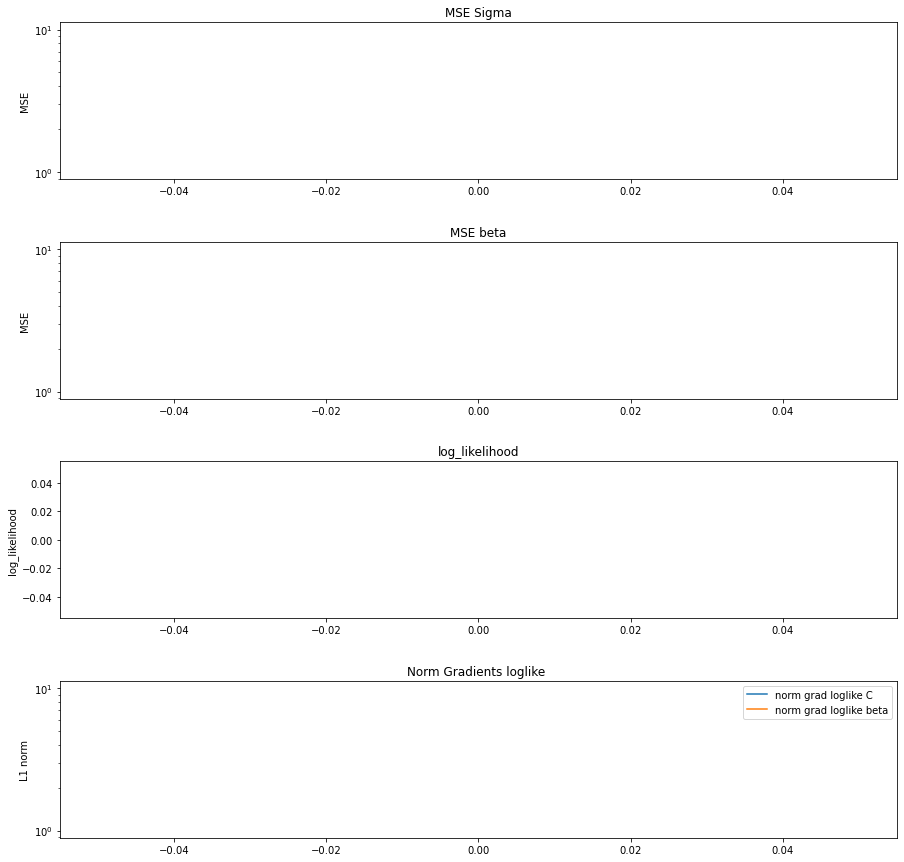

In [182]:
show(model,'')

In [223]:
def exp_moment(t,mu,Sigma):
    '''
    computes the exponential moment of a gaussian of mean mu and variance Sigme
    '''

    return torch.exp(mu@t + 1/2*t.reshape(1,-1)@Sigma@(t.reshape(-1,1)))

In [479]:
N = 2
Sigma = torch.eye(N)
inv_Sigma = torch.inverse(Sigma)
t = torch.ones(N)
mu = torch.zeros(N)+1

mu_prop = torch.zeros(N)#+argmax

Sigma_prop = 1*torch.eye(N)

inv_Sigma_prop = torch.inverse(Sigma_prop)

In [480]:
def get_var(weights): 
    nb_weights = weights.shape[0]
    return torch.var(weights)/nb_weights

In [140]:
def estimate_normalizer(f)

(1.772453850905516, 1.976815268282025e-10)

In [141]:
np.sqrt(np.pi)

1.7724538509055159

## 2D 

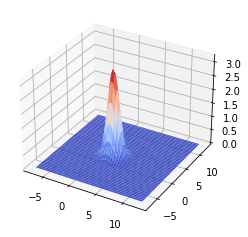

In [481]:
def IMPS(f, p, q, acc):
    N_samples = int(1/acc)
    sqrtm_prop = torch.from_numpy(SLA.sqrtm(Sigma_prop))
    weights = torch.zeros(N_samples)
    W = torch.randn(N_samples,N)+mu_prop
    for i in range(N_samples):
        weights[i] = p(W[i])/q(W[i])
    weights/= torch.sum(weights)
    var = get_var(weights)
    return torch.sum(torch.squeeze(f(W))*weights), var 
    
def f(Z):
    if len(Z.shape)> 1 : 
        t = torch.ones(Z.shape[1],1)
    else : 
        t = torch.ones(Z.shape)
    return torch.exp(Z@t)

def Ndensity(Z,mu,inv_Sigma): 
    return torch.exp(-1/2*(Z-mu).reshape(1,-1)@inv_Sigma@((Z-mu).reshape(-1,1)))/(torch.sqrt(1/torch.det(inv_Sigma)*(2*math.pi)**N))      
def p(Z): 
    return Ndensity(Z,mu,inv_Sigma)
def q(Z): 
    return Ndensity(Z,mu_prop, inv_Sigma_prop) 
    

Z_exp_moment,argmax_2D = plot_2D(f_expmoment,abscisse,abscisse)

In [482]:
abscisse = torch.linspace(-10+argmax,10+argmax,200)

mu_prop = torch.zeros(N)+torch.tensor(list(argmax_2D))

true_val  = exp_moment(t,mu,Sigma)

guess, var = IMPS(f,p,q, 0.0001)
print('our guess : ', guess)
print('true : ', true_val)
print('variance : ', var)

our guess :  tensor(20.0912)
true :  tensor([[20.0855]])
variance :  tensor(5.9005e-12)


## la variance a l'air de jouer un gros role, si elle est trop grande, l'estimateur est biaisé. peut etre y a til un probleme de densité

In [477]:
argmax_2D

(tensor(1.9849), tensor(1.9849))

In [320]:
def plot_2D(f,x_abscisse, y_abscisse):
    Z = np.zeros((len(x_abscisse), len(y_abscisse)))
    maxi = 0
    argmax = (0,0)
    for i,x in enumerate(x_abscisse): 
        for j,y in enumerate(y_abscisse):
            xy_ten = torch.tensor([x,y])
            value = (f(xy_ten))
            if value > maxi : 
                argmax = (i,j)
                maxi = value
            
            Z[i,j]= value
            
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    X,Y = np.meshgrid(x_abscisse,y_abscisse)
    ax.plot_surface(X, Y, Z.T, cmap = cm.coolwarm)
    plt.show()
    return Z, (abscisse[argmax[0]],abscisse[argmax[1]]) 
    

    
def f_expmoment(Z): 
    return torch.exp(torch.sum(Z))*p(Z)





RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x2 and 1x1)

In [317]:
argmax_2D

NameError: name 'argmax_2D' is not defined

tensor(1.9598)


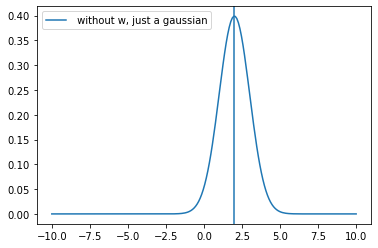

In [252]:
def plot_1D(f, abscisse): 
    values = list()

    for w in abscisse : 
        valeur = torch.tensor([w])
        values.append(np.squeeze((valeur*f(valeur)).numpy()))

    argmax = abscisse[np.argmax(values)]
    plt.plot(abscisse,np.abs(values))
    plt.axvline(argmax)
    plt.show()
    return argmax

    

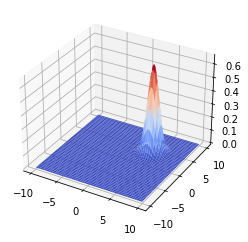

In [93]:

Z = np.zeros((len(abscisse), len(abscisse)))
for i,x in enumerate(abscisse): 
    for j,y in enumerate(abscisse) :
        xy_ten = torch.tensor([x,y])
        Z[i,j]= (p(xy_ten))*torch.tensor([y])
        

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X,Y = np.meshgrid(abscisse,abscisse)
ax.plot_surface(X, Y, Z, cmap = cm.coolwarm)
plt.show()

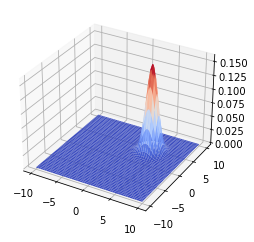

In [94]:
abscisse = torch.linspace(-10,10,200)
Z = np.zeros((len(abscisse), len(abscisse)))
for i,x in enumerate(abscisse): 
    for j,y in enumerate(abscisse) :
        xy_ten = torch.tensor([x,y])
        Z[i,j]= (p(xy_ten))
        

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X,Y = np.meshgrid(abscisse,abscisse)
ax.plot_surface(X, Y, Z, cmap = cm.coolwarm)
plt.show()

In [157]:
Z_exp_moment

array([[3.49943382e-35, 6.38250258e-35, 1.15226691e-34, ...,
        1.69443686e-30, 1.14868132e-30, 7.70801592e-31],
       [1.05178988e-34, 1.91832506e-34, 3.46325358e-34, ...,
        5.09279966e-30, 3.45247674e-30, 2.31672137e-30],
       [3.12948940e-34, 5.70777310e-34, 1.03045443e-33, ...,
        1.51530861e-29, 1.02724790e-29, 6.89315913e-30],
       ...,
       [1.01571620e-25, 1.85253146e-25, 3.34447291e-25, ...,
        4.91812977e-21, 3.33406569e-21, 2.23726380e-21],
       [4.17371943e-26, 7.61230999e-26, 1.37429054e-25, ...,
        2.02092808e-21, 1.37001406e-21, 9.19322882e-22],
       [1.69780349e-26, 3.09656811e-26, 5.59039800e-26, ...,
        8.22081791e-22, 5.57300198e-22, 3.73966105e-22]])

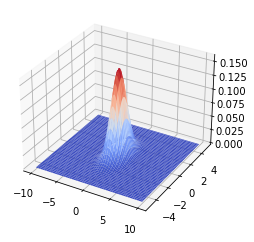

In [153]:
plot_2D(p,abscisse,torch.linspace(-5,5,100))

In [65]:
X = np.arange(-5, 5, 1)
Y = np.arange(-5, 5, 1)
X, Y = np.meshgrid(X, Y)
print(X)
print(Y)

[[-5 -4 -3 -2 -1  0  1  2  3  4]
 [-5 -4 -3 -2 -1  0  1  2  3  4]
 [-5 -4 -3 -2 -1  0  1  2  3  4]
 [-5 -4 -3 -2 -1  0  1  2  3  4]
 [-5 -4 -3 -2 -1  0  1  2  3  4]
 [-5 -4 -3 -2 -1  0  1  2  3  4]
 [-5 -4 -3 -2 -1  0  1  2  3  4]
 [-5 -4 -3 -2 -1  0  1  2  3  4]
 [-5 -4 -3 -2 -1  0  1  2  3  4]
 [-5 -4 -3 -2 -1  0  1  2  3  4]]
[[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
 [-4 -4 -4 -4 -4 -4 -4 -4 -4 -4]
 [-3 -3 -3 -3 -3 -3 -3 -3 -3 -3]
 [-2 -2 -2 -2 -2 -2 -2 -2 -2 -2]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 1  1  1  1  1  1  1  1  1  1]
 [ 2  2  2  2  2  2  2  2  2  2]
 [ 3  3  3  3  3  3  3  3  3  3]
 [ 4  4  4  4  4  4  4  4  4  4]]


In [48]:
Y

array([[-5.  , -5.  , -5.  , ..., -5.  , -5.  , -5.  ],
       [-4.75, -4.75, -4.75, ..., -4.75, -4.75, -4.75],
       [-4.5 , -4.5 , -4.5 , ..., -4.5 , -4.5 , -4.5 ],
       ...,
       [ 4.25,  4.25,  4.25, ...,  4.25,  4.25,  4.25],
       [ 4.5 ,  4.5 ,  4.5 , ...,  4.5 ,  4.5 ,  4.5 ],
       [ 4.75,  4.75,  4.75, ...,  4.75,  4.75,  4.75]])

$$
\nabla_{\beta} p_{\theta}\left(Y \mid W_k\right)=p_{\theta}\left(Y \mid W_k\right)\left[-X^{\top} \exp \left(0+X\beta+W_k^{\top} C^{\top}\right)+ X^{\top}Y\right]
$$

$$
\nabla_{C} p_{\theta}\left(Y \mid W_k\right)=p_{\theta}\left(Y \mid W_k\right)\left[Y-\exp \left(0+X \beta+W_k^{\top} C^{\top} \right)\right]
^{\top}W_k 
$$

$$
\begin{aligned}
P_{\theta}\left(Y_{i} \mid W_{i,k}\right) &=\prod_{j=1}^{p} p_{\theta}\left(Y_{i j} \mid W_{i,k}\right) \\
&=\prod_{j=1}^{P} \frac{1}{Y_{i j} !} \exp \left(-\exp \left(o_{i j}+z_{i j}\right)\right) \exp \left(o_{i j}+z_{i j}\right)^{Y_{ij}}
\end{aligned}
$$
$$
Z_{i j}=x_{i}^{\top} \beta_{j}+W_{i,k}^{\top} C^{\top} _{j}
$$




In [19]:
def poiss_density(mean, k ): 
    return 1/factorial(k)*np.exp(-mean)*mean**k

#print([poiss_density(i,i) for i in range(70)])
    

In [50]:

    def get_conditional_density_j(self, j,Y_i,covariates_i, O_i,best_mean,  N_points): 
        '''
        get the conditional density on the dimension j (i.e. the density of W_j|(Y_i,W_-j) ). We will return 
        a list of some points of the density to plot it. 
        
        
        args : 
            Y_i : tensor of size p 
            covariates_i : tensor of size d 
            O_i : tensor of size p 
            best_mean : tensosr of size q. The mean of the best gaussian approximation you found. 
            N_points : int. The number of points you want in your plot. 100 is a good choice in general. 
        returns : 
            abscisse : a list that discretize the space of interest. i.e. a discretazion of 
            [best_mean[j]-3, best_mean[j]+3]
            density : the value of P_WYgivenY along the abscisse, for W_-j fixed and W_j is moving along the  abscisse. 
        '''
        #We get a mask so that we can fixed the values of best_mean except the j-th coordinate. We will move 
        # the j-th coordinate along the abscisse. 
        mask = torch.zeros(best_mean.shape[0], dtype = torch.bool)
        mask[j]= True
        #get the abscisse. for the abscisse, the space of interest is around best_mean[j] since 
        #W_j|Y_i,W_-j is roughly a gaussian centered in best_mean[j]
        abscisse = np.linspace(best_mean[j].detach().numpy()-3,best_mean[j].detach().numpy()+3,N_points)
        list_density = np.array([self.log_P_WYgivenY(Y_i,covariates_i,O_i,
                        best_mean.masked_scatter(mask,torch.Tensor([w]))).detach().numpy()
                                for w in abscisse])
        list_density-= np.max(list_density)# we remove the max to avoid nan Values when we take the exponential 

        density = np.exp(list_density)# we had the log so we need to take the exp now 
        
        return abscisse,density
    
    
    def plot_conditional(self,Y_b, covariates_b, O_b,gaussian_mean_b, N_points = 100):
        '''
        plot the density of the conditional densities W_j|Y_i,W_-j for i in range(self.batch_size) 
        and j in range(q)
        Thus, the figure  will contain n_batch*q plot. 
        
        args : 
            Y_b : tensor of size (n_batch,p) 
            covariates_b : tensor of size (n_batch,d) 
            O_b : tensor of size (n_batch,p) 
            gaussian_mean_b : tensor of size (n_batch,q) that contains the mean of the best gaussian
            approximation 
            N_points : the number of points you want in your plot. The larger the smoother the curve. 
            
        returns : None, but display the figure
        '''
        
        fig = plt.figure(figsize = (20,10))
        axes = fig.subplots(gaussian_mean_b.shape[0], gaussian_mean_b.shape[1])
        for i, (Y_i,covariates_i, O_i, gaussian_mean_i) in enumerate(zip(Y_b, covariates_b, O_b,gaussian_mean_b)): 
            for j in range(gaussian_mean_b.shape[1]): 
                abscisse, density = self.get_conditional_density_j(j,Y_i,covariates_i, O_i, gaussian_mean_i, N_points)
                true_max = abscisse[np.argmax(density)]# get the true max to plot it. 
                
                #normal_density = np.exp(np.array([-1/(2*self.sigma**2)*(w-gaussian_mean_b[i,j])**2 for w in abscisse])) 
                try : 
                    #density of a gaussian centered in gaussian_mean_b[i,j] to see the approximation
                    normal_density = np.exp(np.array([-1/(2*self.sigma**2)*(w-gaussian_mean_b[i,j].item())**2 for w in abscisse])) 
                    normal_density*= np.max(density)/np.max(normal_density)# We renormalize by some constants to plot similar things. 
                    axes[i,j].plot(abscisse, density, label = 'W|Y density')
                    axes[i,j].plot(abscisse, normal_density, label = 'Gaussian density')
                    axes[i,j].axvline(gaussian_mean_b[i,j], c = 'green', label = 'maximum found') # the max we found
                    axes[i,j].axvline(true_max, c = 'black', label = 'true_max')# the true max. 
                except : 
                    pass
                
        # We display the labels above and once. 
        lines, labels = fig.axes[0].get_legend_handles_labels()
        fig.legend(lines, labels, loc = 'upper center')
        plt.show()


    def batch_grad_log_beta(self, Y_b,covariates_b, O_b, W):
        '''
        computes the gradient of the log of the density for a batch, with respect to beta. 
        
        args:
            Y_b : tensor of size (n_batch,p) 
            covariates_b : tensor of size (n_batch,d) 
            O_b : tensor of size (n_batch,p) 
            W : tensor of size (N_samples, n_batch, self.q). Should be a gaussian. 
            
        returns : 
            the gradient of the log of the density. The formula is above. 
        '''
        #we do not sum up since we will need to multiply each quantity with a Monte Carlo approximation
        Z_b = O_b + covariates_b@self.beta + W@(self.C.T)
        return  (covariates_b.unsqueeze(2).T@(-torch.exp(Z_b)+Y_b)) # unsqueeze is here so that the transpose
                                                                    #makes sense
    
    def grad_log_beta(self, Y_i, covariates_i, O_i, V_k): 
        '''
        same as batch_grad_log_beta but for only one sample Y_i, covariates_i and O_i. 
        '''
        Z_i = O_i + covariates_i@self.beta + V_k@(self.C.T)
        return covariates_i.unsqueeze(1)@((-torch.exp(Z_i)+Y_i).unsqueeze(0))
    
    def batch_grad_log_C(self, Y_b,covariates_b, O_b, W):
        '''
        same as batch_grad_log_beta but the gradients is taken with respect to C.
        '''
        #we do not sum up since we will need to multiply each quantity with a Monte Carlo approximation
        Z_b = O_b + covariates_b@self.beta + W@(self.C.T)
        return ((-torch.exp(Z_b)+Y_b).permute(0,2,1)@W)
    
    def grad_log_C(self, Y_i, covariates_i, O_i, V_k): 
        '''
        same as grad_log_beta but the gradient is taken with respect  to C. 
        '''
        Z_i = O_i + covariates_i@self.beta + V_k@(self.C.T)
        return ((-torch.exp(Z_i)+Y_i).unsqueeze(1))@V_k.unsqueeze(0)
        
    def get_batch_weights(self, Y_b, covariates_b, O_b,V_b, gaussian_mean_b):
        '''
        function to get the weights (weights formula in the importance sampling)
        for one batch . We take the log and then the exponential to avoid Nan values. 
        args : 
            Y_b : tensor of size (n_batch,p) 
            covariates_b : tensor of size (n_batch,d) 
            O_b : tensor of size (n_batch,p) 
            V_b : torch of size (n_samples, n_batch,q). should be a gaussian. 
            gaussian_mean_b : tensor of size(n_batch,q). 
            
        return : the weights (formula above), of size (n_batch)
        '''
        # see formula above. 
        log_f = self.batch_log_P_WYgivenY(Y_b,covariates_b,O_b,V_b)
        log_g = self.batch_log_g(V_b,gaussian_mean_b)
        log_fminus_log_g = log_f -log_g 
        return torch.exp(log_fminus_log_g - torch.max(log_fminus_log_g, axis = 0 )[0]) #C*f/g

def find_each_mean(self,Y_b,covariates_b, O_b, lr = 0.5, N_iter_max = 100,class_optimizer = torch.optim.Rprop):
        '''
        method to compute the mean of the best gaussian approximation of W|Y_b. We will compute n_batch * q 
        approximation. 
        
        args : 
            Y_b : tensor of size (n_batch,p) 
            covariates_b : tensor of size (n_batch,d) 
            O_b : tensor of size (n_batch,p) 
            lr : float. positive. the learning rate of the optimizer
            N_iter_max : the number of iteration you want to do. 
            class_optimizer : torch.optim.optimizer object.  the class of the optimizer. should be like 
                              torch.optim.Rprop. 
        returns : 
                W : the parameter that maximizes the log of the probability of P_WY given Y.
        '''
        W = torch.randn(self.batch_size,self.q) # here only to evaluate a function, we won't use it to 
                                                # approximate some function. 
        W.requires_grad_(True)
        optimizer = class_optimizer([W], lr = lr)
        i = 0
        while i < N_iter_max:  #and delta > tol :
            loss = -self.each_log_P_WYgivenY(Y_b,covariates_b, O_b, W) #compute the loss 
            loss.mean().backward()#We take the mean since we have a loss of (n_batch,q) dimensions. 
            optimizer.step()
            i+=1
            optimizer.zero_grad()
            if torch.isnan(loss).any() : 
                print('NANloss, find_each_mean funct : ', loss)
            
        return W 
    
    def fit_IMPS(self,Y, O, covariates,  N_iter, acc,lr,class_optimizer = torch.optim.Rprop): 
        '''
        method that fit the parameters C and beta  of the model according to the data Y,O, covariates. 
        We maximize the log likelihood thanks to a gradient ascent. The gradients are computed thanks to 
        importance sampling. 
        
        args : 
                Y : the counts, should be int. tensor of size(n,p)
                O : the offsets : tensor of size (n,p)
                covariates : the covariates of the model. tensor of size(n,d)
                N_iter : int : the number of iteration you want to do. 
                acc : float : the accuracy you want when you compute the gradients and the likelihood. We will 
                sample 1/int samples.
                lr : float, positive. the learning rate of the optimizer for C and beta.
                class_optimizer : the optimizer you want, ex : torch.optim.Rprop. It should be a torch.optim object
        returns : 
                None, but the parameters C and beta are optimized. 
        '''
        self.t0= time.time()# to keep track of the time. 
        self.init_data(Y,O, covariates)# initialize the data. 
        optim = class_optimizer([self.beta,self.C], lr = lr) # optimizer on C and beta
        optim.zero_grad() # We do this since it is possible that beta and C have gradients. 
        N_samples = int(1/acc) # We will sample 1/acc gaussians
        for i in range(N_iter):
            #self.compute_mean_log_likelihood(acc)
            for i, (Y_b, covariates_b, O_b) in enumerate(self.get_batch(self.batch_size)):
                
                if i //10 == 0 : 
                    print('MSE Sigma ', torch.mean((self.get_Sigma()-true_Sigma)**2).item())
                    print('-------------MSE beta : ', torch.mean((self.beta-true_beta)**2).item())
                 # we find the best gaussian_mean for the approximation
                gaussian_mean_b =  self.find_each_mean(Y_b, covariates_b, O_b,N_iter_max = 100)
                if i == -1 : 
                    self.gaussian_list.append(gaussian_mean_b)
                    #self.plot_conditional(Y_b, covariates_b, O_b,gaussian_mean_b)
                #print('gaussian ' , gaussian_mean_b)
                self.compute_batch_mean_log_likelihood(Y_b, covariates_b, O_b,gaussian_mean_b,i,acc)
                # sample some gaussians with the mean of the best gaussian approximation we found
                V_b = torch.randn(N_samples,self.batch_size, self.q)*self.sigma+gaussian_mean_b
                
                weights =  self.get_batch_weights(Y_b, covariates_b, O_b,V_b, gaussian_mean_b) # weights
                
                normalized_weights = weights/torch.sum(weights, axis = 0)#normalization (see formula above)
                
                # gradients of the log likelihood 
                grad_C = self.batch_grad_log_C( Y_b,covariates_b, O_b, V_b)
                grad_beta = self.batch_grad_log_beta( Y_b,covariates_b, O_b, V_b)
                # We mulitplu this with the weights (see formula)
                grad_C = torch.multiply(grad_C.unsqueeze(1),normalized_weights.unsqueeze(2).unsqueeze(3))
                grad_beta = torch.multiply(grad_beta.unsqueeze(1),normalized_weights.unsqueeze(2).unsqueeze(3))
                # We sum over the batches and the samples (maybe take the mean along the batch axis or not)
                grad_C = torch.mean(torch.sum(grad_C, axis = (0)), axis = 0)
                grad_beta = torch.mean(torch.sum(grad_beta, axis = (0)), axis = 0)

                self.C.grad = -grad_C 
                self.beta.grad = -grad_beta
                # keep records 
                self.MSE_Sigma_list.append(torch.mean((self.get_Sigma()-true_Sigma)**2).item())
                self.MSE_beta_list.append(torch.mean((self.beta-true_beta)**2).item())
                self.norm_grad_log_beta_list.append(torch.norm(grad_beta).item())
                self.norm_grad_log_C_list.append(torch.norm(grad_C).item())
                self.running_times.append(time.time()-self.t0)
                optim.step()
                optim.zero_grad()
            print('-----------------------------------------------------------------------------')
            print('-----------------------------------------------------------------------------')
            print('-----------------------------------------------------------------------------')
            print('----------------------------------------------------------------------------------------------------------------------------------------NEWBATCH')

    def batch_log_g(self,V_b, gaussian_mean_b): 
        '''
        method that computes the log of the density of a gaussian of mean gaussian_mean_b and variance 
        self.sigma*I. 
        
        args : 
            V_b : tensor of size (n_samples, n_batch, self.q). 
            
        returns : 
            the log density for each self.q dimensional gaussian (i.e. a tensor of size (n_samples, n_batch))
        '''
        
        const = -self.q/2*math.log(2*math.pi)-self.q*math.log(self.sigma) # the constant on the gaussian   
        return const -1/(2*self.sigma**2)*torch.norm(V_b-gaussian_mean_b, dim = 2)**2

1

In [ ]:
'''
    def likelihood_grad_batch_beta(self, Y_b,covariates_b, O_b, W):
        likelihood = self.batch_likelihood(Y_b,covariates_b, O_b, W, mean = False)
        Z_b = O_b + covariates_b@self.beta + W@(self.C.T)
        nb_non_zero = torch.sum(likelihood >0)
        grad_log = (covariates_b.unsqueeze(2).T@(-torch.exp(Z_b)+Y_b))
        if nb_non_zero > 0 : 
            self.norm_grad_log_beta_list.append(torch.mean(torch.abs(torch.sum(grad_log, axis = 0)/nb_non_zero)).item())
        
        return torch.sum(likelihood.reshape(-1,1,1)*grad_log, axis = 0)/nb_non_zero



    def likelihood_grad_batch_C(self, Y_b,covariates_b, O_b, W): 
        likelihood =  self.batch_likelihood(Y_b,covariates_b, O_b, W, mean = False)
        Z_b = O_b + covariates_b@self.beta + W@(self.C.T)
        grad_log = ((-torch.exp(Z_b)+Y_b).permute(0,2,1)@W)
        nb_non_zero = torch.sum(likelihood >0)
        #print('non_zero : ', nb_non_zero)
        if nb_non_zero > 0 : 
            self.norm_grad_log_C_list.append(torch.mean(torch.abs(torch.sum(grad_log, axis = 0)/nb_non_zero)).item())
            
        return torch.sum(likelihood.reshape(-1,1,1)*grad_log, axis = 0)/nb_non_zero 
'''

This is if we take only one sample $Y_i$. If we take the whole dataset (or a mini-batch), we get (writed in matrix form) :

$$
\nabla_{\beta} p_{\theta}\left(Y \mid W_k\right)=p_{\theta}\left(Y \mid W_k\right)\left[-X^{\top} \exp \left(0+X\beta+W_k^{\top} C^{\top}\right)+ X^{\top}Y\right]
$$

$$
\nabla_{C} p_{\theta}\left(Y \mid W_k\right)=p_{\theta}\left(Y \mid W_k\right)\left[Y-\exp \left(0+X \beta+W_k^{\top} C^{\top} \right)\right]
^{\top}W_k 
$$

We look for a law that is closer to : 

$$
p_{target}(W) := \frac{p_{target}^{(u)}(W)}{\int p_{target}^{(u)}(W)}
$$

$$
p_{target}^{(u)}(W) : = p_{\theta}\left(Y_{i} \mid W\right) p(W_{i,k}) |\nabla_{\theta} \ln p_{\theta}\left(Y_{i} \mid W\right)|
$$